In [3]:
from gym import Env
from gym.spaces import Discrete, Box, Tuple, Dict, MultiDiscrete, MultiBinary
from gym.wrappers import FlattenObservation
import numpy as np
from numpy import ndarray
from scipy.integrate import trapz
from scipy.integrate import quad
from random import randint, random, uniform
import pygame 

# Blockchain Environment using Gym

In [7]:
class blockEnv(Env):
    
    def __init__(self):
        
        #blockchain parameters
        self.max_blocks = 200 #current number of blocks on the blockchain
        self.cloud_blocks = 0 #number of blocks sent to cloud
        self.chain_size = 0 #total blockchain size
        self.avg_block_size = 1048576 #1MB
        
        #local storage parameters
        #self.loc_storage_max = 262144000 #250MB
        self.loc_storage_max =  314572800 #300MB physical storage in bytes
        #self.loc_storage_max =  524288000 #500MB storage in bytes
        self.all_blocks = self.loc_storage_max / self.avg_block_size #maximum number of blocks given average block size and total available physical storage
        #self.loc_storage_limit = 167772160 #160MB storage (40% of physical storage)
        self.loc_storage_limit = 157286400 #150MB storage
        
        #objective functions - initial 
        self.loc_occupancy = 1 #maximum local occupancy
        self.init_query_freq = 0.95
        self.cloud_query_prob = 0
        self.sum_query_prob = 0
        self.norm_query_prob = 0
        self.att_coef = 0.01
        self.cloud_cost_obj = 0
        self.tradeoff = 0.1
          
        
        #cloud parameters
        self.cloud_storage = 0
        self.cloud_cost = 0
        self.cloud_storage_inc = 104857600 #per 100MB = $0.15 per MB per month + $0.0228 + $0.0019 +$0.0019
        self.cloud_cost_limit = 0.1766 #100MB cloud cost
        self.rtt_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]#ping.psa.fun aws latency tool provided latency values
        self.latency = np.random.choice(self.rtt_list)
        #self.bandwidth = 4125000 #33Mbps
        
        #episode length
        self.episode_length = self.max_blocks * 2
        
        #objective function weights
        self.query_prob_w = 0.5
        self.cloud_cost_w = 0.2
        self.loc_occupancy_w = 0.3
        
        #action space
        self.action_space = Discrete(self.max_blocks + 1) #if 0 means no block selected
        
        #observation space
        self.observation_space = Dict({
                                             'initial query frequency': Box(low = 0, high = 1, shape=(1,self.max_blocks + 1),dtype=np.float16),# value between 0 and 1
                                             'block size': Box(low = 1024, high = 2097152, shape= (1,self.max_blocks + 1), dtype= np.int), #maximum block size is 2 MB
                                             'block status': MultiBinary(self.max_blocks + 1) #0 for local, 1 for cloud
                                                                                                         })
        
        
        self.state = ({
                        'initial query frequency': np.zeros(self.max_blocks + 1),
                        'block size': np.zeros(self.max_blocks + 1),
                        'block status': np.zeros(self.max_blocks + 1)  
                      })
        
        for i in range(1, self.max_blocks + 1):
            self.state['initial query frequency'][i] = self.init_query_freq
            self.state['block size'][i] = randint(1,2097152) 
            self.state['block status'][i] = 0
            self.chain_size += self.state['block size'][i]
            
            if i < self.max_blocks:
                self.query_prob = 1 / (self.state['initial query frequency'][i] * (self.max_blocks - i))
            else:
                self.query_prob = self.state['initial query frequency'][i]
                
            self.sum_query_prob += self.query_prob 
            
            
        
        self.cloud_cost_max = (self.tradeoff * self.latency) + (0.1766 * (self.chain_size/self.cloud_storage_inc))
        
        self.loc_storage = self.chain_size
        
        
        
        
    def step(self, action):
        
        reward = 0 #initial assignment
        
        self.episode_length -= 1 #reduce by 1
        
        if action != 0:
            #query probability determination
            if action < self.max_blocks:
                self.query_prob = 1 / (self.state['initial query frequency'][action] * (self.max_blocks - action)) #query probability for blocks from 1 to the last but one block
            else:
                self.query_prob = self.state['initial query frequency'][action] #query probability for the latest block
                
            self.norm_query_prob = self.query_prob / self.sum_query_prob #normalized query probability
            
            
            #block selection  
            #cloud block selection - move to local    
            if self.state['block status'][action] == 1: 
                self.state['block status'][action] = 0
                self.cloud_blocks -= 1
                self.loc_storage += self.state['block size'][action]
                self.cloud_storage -= self.state['block size'][action]
                self.loc_occupancy = ((np.exp((self.all_blocks - self.cloud_blocks)/self.all_blocks))-1) / (np.exp(1)-1)
                self.cloud_query_prob -= self.norm_query_prob  
            
            #local block selection - move to cloud   
            else: 
                self.state['block status'][action] = 1
                self.cloud_blocks += 1
                self.cloud_cost = 0.1766
                self.cloud_cost_obj = (self.tradeoff * self.latency) + self.cloud_cost
                self.loc_storage -= self.state['block size'][action]
                self.cloud_storage += self.state['block size'][action]
                self.loc_occupancy = ((np.exp((self.all_blocks - self.cloud_blocks)/self.all_blocks))-1) / (np.exp(1)-1)   
                self.cloud_query_prob += self.norm_query_prob
        
        
        #cloud storage exceeds cost class
        if self.cloud_storage > self.cloud_storage_inc: 
           self.cloud_cost += 0.1766
           self.cloud_storage_inc += 104857600
                  
        #Reward conditions    
        self.base_reward = ((self.query_prob_w)*(1 - self.cloud_query_prob)) + ((self.cloud_cost_w)*(1-(self.cloud_cost_obj/self.cloud_cost_max))) + ((self.loc_occupancy_w)*(1 - self.loc_occupancy))
        
                
        self.free_space_factor = (self.loc_storage_limit - self.loc_storage) / self.loc_storage_limit
        
        #self.size_prob_factor1 = self.cloud_cost_w * ((self.state['block size'][action] - self.avg_block_size)/self.state['block size'][action]) + self.query_prob_w * (self.norm_query_prob - 0.5)
        
        #self.size_prob_factor2 = self.cloud_cost_w * ((self.avg_block_size - self.state['block size'][action])/self.avg_block_size) + self.query_prob_w * (0.5 - self.norm_query_prob)
        
        #self.size_prob_factor3 = self.cloud_cost_w * ((self.avg_block_size - self.state['block size'][action])/self.avg_block_size) + self.query_prob_w * (self.norm_query_prob - 0.5)
        
        #self.size_prob_factor4 = self.cloud_cost_w * ((self.state['block size'][action] - self.avg_block_size)/self.state['block size'][action]) + self.query_prob_w * (0.5 - self.norm_query_prob)
        
        
        
        if self.loc_storage < self.loc_storage_limit and self.cloud_cost <= self.cloud_cost_limit: #check if local storage and storage cost are within limits
            reward = self.base_reward #positive reward
         
        if self.loc_storage >= self.loc_storage_limit and self.cloud_storage  == 0:#check if local storage limit is broken and cloud storage is at zero
            reward -= self.base_reward #negative reward
                            
        if self.loc_storage >= self.loc_storage_limit and self.cloud_storage > 0:#check if local storage limit is broken but cloud storage is increasing
            reward = self.free_space_factor * self.base_reward
                   
        #end episode when at zero
        if self.episode_length <= 0: 
           done = True
        else:
           done = False
    
        #emergency reward condition
        if self.cloud_cost > self.cloud_cost_limit:#check if cloud cost exceeds limit
            reward = 0
            done = True   
        
        
        self.latency = np.random.choice(self.rtt_list)
        
        
        info = ({'cloud blocks': self.cloud_blocks,
                'total blocks': self.max_blocks,
               'blockchain local storage': self.loc_storage,
               'blockchain cloud storage': self.cloud_storage,
               'query probability': self.cloud_query_prob,
               'cloud storage cost': self.cloud_cost_obj,
               'local space occupancy': self.loc_occupancy
                                                })
    
        return self.state, reward, done, info
    
    
    def render(self, mode="human"):
        pass
    
    def reset(self):
        
        self.max_blocks = 200
        self.cloud_blocks = 0 
        self.cloud_cost = 0
        self.cloud_cost_obj = 0
        self.cloud_storage_inc = 104857600
        self.cloud_storage = 0
        self.episode_length = self.max_blocks * 2
        self.chain_size = 0
        self.sum_query_prob = 0
        self.cloud_query_prob = 0
        self.latency = np.random.choice(self.rtt_list)
        
        self.state = ({
                        'initial query frequency': np.zeros(self.max_blocks + 1),
                        'block size': np.zeros(self.max_blocks + 1),
                        'block status': np.zeros(self.max_blocks + 1)  
                      })
        
        for i in range(1, self.max_blocks + 1):
            self.state['initial query frequency'][i] = self.init_query_freq 
            self.state['block size'][i] = randint(1,2097152) 
            self.state['block status'][i] = 0
            self.chain_size += self.state['block size'][i]
            
            if i < self.max_blocks:
                self.query_prob = 1 / (self.state['initial query frequency'][i] * (self.max_blocks - i))
            else:
                self.query_prob = self.state['initial query frequency'][i]
                
            self.sum_query_prob += self.query_prob 
        
        self.cloud_cost_max = (self.tradeoff * self.latency) + (0.1766 * (self.chain_size/self.cloud_storage_inc))
        
        self.loc_storage = self.chain_size
        
        return self.state
        

In [ ]:
env = blockEnv()

print(env.loc_storage)

In [ ]:
env = blockEnv()

env.chain_size

env.reset()

env.chain_size

In [ ]:
env = blockEnv()

print(env.chain_size)

#test_sizes = np.zeros(201)
sum = 0
for i in range (1, 201):
    sum += env.state['block size'][i]

print(sum)  

env.reset()

print(env.chain_size)

#test_sizes = np.zeros(201)
sum = 0
for i in range (1, 201):
    sum += env.state['block size'][i]

print(sum)  


In [ ]:
test_sizes = np.zeros(201)
sum = 0
for i in range (1, 201):
    test_sizes[i] = randint(1,2097152)
    sum += test_sizes[i]

print(test_sizes)

print(sum)  

# Test using Random Agent

In [5]:
env = blockEnv()
episodes = 20
random_rec_rewards = np.zeros(episodes)
cloud_block_no = np.zeros(episodes)
total_size = np.zeros(episodes)
cloud_size = np.zeros(episodes)
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    step = 0 
    total_reward = 0
    
    while not done:
        step += 1      
        action = env.action_space.sample()
        env.state, reward, done, info = env.step(action)
        print('Step:{} Selected block:{} New Block Status:{} Block size:{} Query Probability:{} Cloud Cost:{} Maximum Cloud Cost:{} Cloud Blocks:{} Local Space Occupancy:{} Reward:{}'.format(step, action, env.state['block status'][action], env.state['block size'][action], env.cloud_query_prob, env.cloud_cost, env.cloud_cost_max, env.cloud_blocks, env.loc_occupancy, reward))
        total_reward += reward
    
    print('Episode:{} Reward:{} Blocks:{} Cloud Blocks:{}'.format(episode, total_reward, env.max_blocks, env.cloud_blocks))
    random_rec_rewards[episode - 1] = total_reward
    cloud_block_no[episode - 1] = env.cloud_blocks
    total_size[episode - 1] = env.loc_storage
    cloud_size[episode - 1] = env.cloud_storage

Step:1 Selected block:156 New Block Status:1.0 Block size:1730370.0 Query Probability:0.0033543161268526104 Cloud Cost:0.1766 Maximum Cloud Cost:0.34904207121658326 Cloud Blocks:1 Local Space Occupancy:0.9947355233127622 Reward:-0.11014616177588685
Step:2 Selected block:22 New Block Status:1.0 Block size:1078368.0 Query Probability:0.004183472922254379 Cloud Cost:0.1766 Maximum Cloud Cost:0.34904207121658326 Cloud Blocks:2 Local Space Occupancy:0.9894885656665257 Reward:-0.11111035531525182
Step:3 Selected block:125 New Block Status:1.0 Block size:256495.0 Query Probability:0.006151338383341244 Cloud Cost:0.1766 Maximum Cloud Cost:0.34904207121658326 Cloud Blocks:3 Local Space Occupancy:0.9842590687617065 Reward:-0.1145133195070931
Step:4 Selected block:27 New Block Status:1.0 Block size:422485.0 Query Probability:0.0070044592479742785 Cloud Cost:0.1766 Maximum Cloud Cost:0.34904207121658326 Cloud Blocks:4 Local Space Occupancy:0.9790469744927305 Reward:-0.11349475460828021
Step:5 Sele

# DRL Model Implementation with Stable Baselines3

In [8]:
from stable_baselines3 import PPO, A2C, DDPG, DQN 
from stable_baselines3.common.env_util import make_vec_env
from gym.wrappers import FlattenObservation

# Instantiate the env
env = blockEnv()
#wrapped_env = FlattenObservation(env)


# wrap it
env = make_vec_env(lambda: env, n_envs=1)

# 1. A2C

In [50]:
model = A2C('MultiInputPolicy', env, verbose=1, tensorboard_log="logs110822rev300k").learn(300000)
model.save("a2c_block_selection_200b_n1_110822rev300k")

Using cpu device
Logging to logs110822rev300k\A2C_1
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 400      |
|    ep_rew_mean        | 177      |
| time/                 |          |
|    fps                | 355      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -5.27    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 6.96     |
|    value_loss         | 2.03     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 380      |
|    ep_rew_mean        | 168      |
| time/                 |          |
|    fps                | 342      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps   

# 2. PPO

In [51]:
model = PPO('MultiInputPolicy', env, verbose=1, tensorboard_log= "logs110822rev300k").learn(300000)
model.save("ppo_block_selection_200b_n1_110822rev300k")

Using cpu device
Logging to logs110822rev300k\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 304      |
|    ep_rew_mean     | 111      |
| time/              |          |
|    fps             | 720      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 317         |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 540         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019935224 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.29       |
|    explained_varia

# 3. DQN

In [52]:
model = DQN("MultiInputPolicy", env, verbose=1, tensorboard_log="logs110822rev300k").learn(total_timesteps=300000, log_interval=4)
model.save("dqn_block_selection_200b_n1_110822rev300k")

Using cpu device
Logging to logs110822rev300k\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 236      |
|    ep_rew_mean      | 85.7     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3177     |
|    time_elapsed     | 0        |
|    total_timesteps  | 945      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 296      |
|    ep_rew_mean      | 116      |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3873     |
|    time_elapsed     | 0        |
|    total_timesteps  | 2364     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | 130      |
|    exploration_rate | 0.879    |
| t

# Tensorboard Visualization

Load Tensorboard

In [12]:
%load_ext tensorboard
%tensorboard --logdir logs110822rev2k

Reload Tensorboard

In [54]:
%reload_ext tensorboard
%tensorboard --logdir logs110822rev300k

Kill Tensorboard Process

In [53]:
!taskkill /IM "tensorboard.exe" /F
!rmdir /S /Q %temp%\.tensorboard-info

SUCCESS: The process "tensorboard.exe" with PID 18480 has been terminated.


# MatplotLib Visualization

In [ ]:
# importing matplotlib module 
from matplotlib import pyplot as plt

a2c_list_episodes = [1000,
2000,
3000,
4000,
5000,
6000,
7000,
8000,
9000,
10000
]

a2c_rewards_def = [
53.58441544,
50.2064476,
48.76094437,
46.70312119,
45.61433792,
44.40245056,
43.8552742,
43.18827057,
42.65766144,
41.80752563
]

a2c_rewards_01 = [
0.407775015,
-1.131630659,
-1.424850702,
-1.644765854,
-1.730288386,
-1.815810919,
-1.856056809,
-1.901333451,
-1.924657702,
-1.952646971
]

a2c_rewards_001 = [
3.217624426,
3.267982006,
3.761151791,
4.131029129,
4.274870396,
4.418711185,
4.486401081,
4.562552452,
4.601781845,
4.648857117
]

a2c_rewards_0001 = [
14.06940079,
13.66944122,
12.82737446,
12.12328148,
12.24067688,
12.56417274,
12.40751266,
12.38443851,
12.45897484,
12.57828236
]

a2c_rewards_00001 = [
11.63718605,
11.48736286,
11.50144768,
11.40887737,
11.44208717,
11.13067532,
11.08046818,
11.12351704,
11.04597855,
10.95722866
]

plt.plot(a2c_list_episodes, a2c_rewards_def, color = 'red')

plt.plot(a2c_list_episodes, a2c_rewards_00001, color = 'blue')

plt.plot(a2c_list_episodes, a2c_rewards_0001, color = 'green')

plt.plot(a2c_list_episodes, a2c_rewards_001, color = 'brown')

plt.plot(a2c_list_episodes, a2c_rewards_01, color = 'violet')


plt.xlabel("Time Steps")
plt.ylabel("Mean Reward")

plt.legend(["Learning rate - 0.0007","Learning rate - 0.0001","Learning rate - 0.001", "Learning rate - 0.01", "Learning rate - 0.1"])

plt.show()

In [ ]:
ppo_list_episodes = [4096,
8192,
12288
]

ppo_rewards_def = [34.74623108,
32.54196167,
30.95478058
]

ppo_rewards_01 = [20.65874481,
11.29493904,
7.698221684
]

ppo_rewards_001 = [16.83774376,
11.64465141,
9.973834991
]

ppo_rewards_0001 = [13.91521835,
13.63096046,
13.26288033
]

ppo_rewards_00001 = [10.4615097,
10.32739925,
9.999294281
]

plt.plot(ppo_list_episodes, ppo_rewards_def, color = 'red')

plt.plot(ppo_list_episodes, ppo_rewards_00001, color = 'blue')

plt.plot(ppo_list_episodes, ppo_rewards_0001, color = 'green')

plt.plot(ppo_list_episodes, ppo_rewards_001, color = 'brown')

plt.plot(ppo_list_episodes, ppo_rewards_01, color = 'violet')


plt.xlabel("Time Steps")
plt.ylabel("Mean Reward")

plt.legend(["Learning rate - 0.0003","Learning rate - 0.0001","Learning rate - 0.001", "Learning rate - 0.01", "Learning rate - 0.1"])

plt.show()

In [ ]:
dqn_list_episodes = [
1600,
3200,
4800,
6400,
8000,
9600
]

dqn_rewards_def = [24.73731804,
24.77907372,
24.6192627,
24.3403492,
23.86000252,
23.46022987
]

dqn_rewards_01 = [19.22875023,
19.26927757,
19.29726791,
19.01841164,
18.7986908,
18.64960289
]

dqn_rewards_001 = [15.66419125,
15.88648701,
16.20269012,
16.0456543,
15.84923172,
15.79841423
]

dqn_rewards_0001 = [12.29890347,
12.25974655,
12.23945141,
12.10512352,
12.13069248,
12.03194714
]

plt.plot(dqn_list_episodes, dqn_rewards_def, color = 'red')

plt.plot(dqn_list_episodes, dqn_rewards_0001, color = 'blue')

plt.plot(dqn_list_episodes, dqn_rewards_001, color = 'green')

plt.plot(dqn_list_episodes, dqn_rewards_01, color = 'brown')

plt.xlabel("Time Steps")
plt.ylabel("Mean Reward")

plt.legend(["Learning rate - 0.0001","Learning rate - 0.001","Learning rate - 0.01", "Learning rate - 0.1"])

plt.show()


In [ ]:
# importing matplotlib module 
from matplotlib import pyplot as plt

a2c_list_episodes = [
500,
1000,
1500,
2000,
2500,
3000,
3500,
4000,
4500,
5000,
5500,
6000,
6500,
7000,
7500,
8000,
8500,
9000,
9500,
10000
]

a2c_rewards = [
0.823572294,
1,
0,
0.218711872,
0.304403703,
0.423111101,
0.663077915,
0.398115575,
0.369498422,
0.437051618,
0.123392535,
0.241163516,
0.216067333,
0.164301053,
0.202957492,
0.09809707,
0.118559971,
0.134359088,
0.208189634,
0.237324307
]

ppo_list_episodes = [
2048,
4096,
6144,
8192,
10240
]

ppo_rewards = [
0.711774228,
0.068726195,
0,
0.898263903,
1
]

dqn_list_episodes = [
1291,
2529,
3696,
5072,
6349,
7379,
8336,
9644
]

dqn_rewards = [
0.766280396,
0.853198138,
0.528945835,
1,
0.99425999,
0.435568469,
0,
0.133143576
]

plt.plot(a2c_list_episodes, a2c_rewards, color = 'red')

plt.plot(ppo_list_episodes, ppo_rewards, color = 'blue')

plt.plot(dqn_list_episodes, dqn_rewards, color = 'green')

plt.xlabel("Time Steps")
plt.ylabel("Normalized Reward")

plt.legend(["A2C","PPO","DQN"])

plt.show()

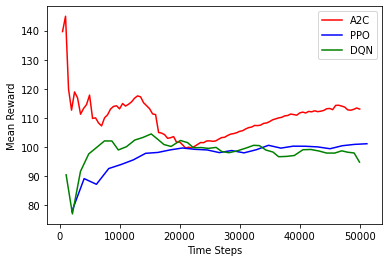

In [16]:
# importing matplotlib module 
from matplotlib import pyplot as plt

a2c_list_episodes = [
500,
1000,
1500,
2000,
2500,
3000,
3500,
4000,
4500,
5000,
5500,
6000,
6500,
7000,
7500,
8000,
8500,
9000,
9500,
10000,
10500,
11000,
11500,
12000,
12500,
13000,
13500,
14000,
14500,
15000,
15500,
16000,
16500,
17000,
17500,
18000,
18500,
19000,
19500,
20000,
20500,
21000,
21500,
22000,
22500,
23000,
23500,
24000,
24500,
25000,
25500,
26000,
26500,
27000,
27500,
28000,
28500,
29000,
29500,
30000,
30500,
31000,
31500,
32000,
32500,
33000,
33500,
34000,
34500,
35000,
35500,
36000,
36500,
37000,
37500,
38000,
38500,
39000,
39500,
40000,
40500,
41000,
41500,
42000,
42500,
43000,
43500,
44000,
44500,
45000,
45500,
46000,
46500,
47000,
47500,
48000,
48500,
49000,
49500,
50000
]

a2c_rewards = [139.67578125,144.950637817382,119.848526000976,112.652633666992,118.905601501464,116.868423461914,111.235855102539,113.213333129882,114.571647644042,117.80891418457,109.803321838378,109.965255737304,108.228950500488,107.228378295898,109.994422912597,111.042030334472,113.029792785644,113.933769226074,114.138900756835,113.080650329589,114.915916442871,114.036804199218,114.676605224609,115.492897033691,116.764297485351,117.547058105468,117.2158203125,115.183792114257,114.177856445312,113.121391296386,111.345581054687,111.119682312011,104.955688476562,104.734924316406,104.208580017089,102.948654174804,103.148162841796,103.536079406738,101.565689086914,101.693481445312,100.703544616699,99.5764236450195,99.8882141113281,99.6366729736328,100.189804077148,100.849861145019,101.495964050292,101.447509765625,102.029624938964,102.07331085205,101.92170715332,102.038909912109,102.63525390625,103.198631286621,103.300827026367,103.921478271484,104.384361267089,104.568862915039,104.865783691406,105.343879699707,105.571472167968,106.168006896972,106.625877380371,106.825126647949,107.38215637207,107.315048217773,107.50104522705,108.085914611816,108.241081237792,108.710868835449,109.322151184082,109.64224243164,109.966117858886,110.167411804199,110.660095214843,110.791946411132,111.295791625976,111.10668182373,110.905517578125,111.662055969238,111.972335815429,111.662117004394,112.202354431152,112.059371948242,112.420082092285,112.116844177246,112.272270202636,112.534835815429,113.116096496582,113.21410369873,112.81787109375,114.275733947753,114.325050354003,114.03343963623,113.690231323242,112.736709594726,112.617385864257,112.91315460205,113.378875732421,113.012107849121]

ppo_list_episodes = [2048,4096,6144,8192,10240,12288,14336,16384,18432,20480,22528,24576,26624,28672,30720,32768,34816,36864,38912,40960,43008,45056,47104,49152,51200]

ppo_rewards = [77.7407531738281,89.0753860473632,87.1248474121093,92.5437774658203,93.9208450317382,95.5250167846679,97.7819442749023,98.0839157104492,98.9567260742187,99.6140670776367,99.1615142822265,98.9524307250976,98.0279312133789,98.7371826171875,97.9424362182617,99.010398864746,100.541877746582,99.5715789794921,100.242378234863,100.216964721679,99.9883193969726,99.3604736328125,100.395301818847,100.857818603515,101.078552246093]

dqn_list_episodes = [1099,2144,3489,4864,6149,7488,8729,9789,11140,12529,13870,15267,16372,17398,18586,20125,21334,22306,23605,24779,26080,27011,28217,29574,30991,32335,33283,34365,35553,36497,37834,39103,40541,41890,43256,44487,45837,47014,47982,49071,49965]

dqn_rewards = [90.3863906860351,76.9304275512695,91.565071105957,97.5802154541015,99.7498168945312,102.050567626953,102.018951416015,98.9389495849609,100.049774169921,102.34439086914,103.223579406738,104.454605102539,102.585762023925,100.795433044433,100.147407531738,102.20255279541,101.457450866699,99.6950225830078,99.7620315551757,99.4825439453125,99.8172073364257,98.4052429199218,97.9941711425781,98.614143371582,99.5417785644531,100.534484863281,100.439552307128,98.92236328125,98.2149200439453,96.6075286865234,96.7252960205078,97.0304718017578,99.0190734863281,99.0986633300781,98.5566253662109,97.8695983886718,97.8681259155273,98.6412734985351,98.1608963012695,97.9010696411132,94.7524490356445]

plt.plot(a2c_list_episodes, a2c_rewards, color = 'red')

plt.plot(ppo_list_episodes, ppo_rewards, color = 'blue')

plt.plot(dqn_list_episodes, dqn_rewards, color = 'green')

plt.xlabel("Time Steps")
plt.ylabel("Mean Reward")

plt.legend(["A2C","PPO","DQN"])

plt.show()

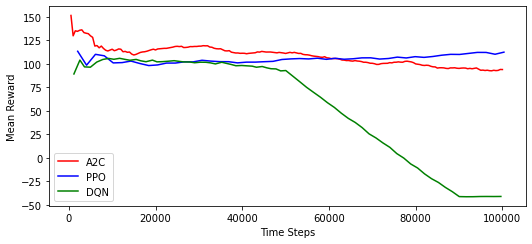

In [13]:
# importing matplotlib module 
from matplotlib import pyplot as plt

a2c_list_episodes = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,12500,13000,13500,14000,14500,15000,15500,16000,16500,17000,17500,18000,18500,19000,19500,20000,20500,21000,21500,22000,22500,23000,23500,24000,24500,25000,25500,26000,26500,27000,27500,28000,28500,29000,29500,30000,30500,31000,31500,32000,32500,33000,33500,34000,34500,35000,35500,36000,36500,37000,37500,38000,38500,39000,39500,40000,40500,41000,41500,42000,42500,43000,43500,44000,44500,45000,45500,46000,46500,47000,47500,48000,48500,49000,49500,50000,50500,51000,51500,52000,52500,53000,53500,54000,54500,55000,55500,56000,56500,57000,57500,58000,58500,59000,59500,60000,60500,61000,61500,62000,62500,63000,63500,64000,64500,65000,65500,66000,66500,67000,67500,68000,68500,69000,69500,70000,70500,71000,71500,72000,72500,73000,73500,74000,74500,75000,75500,76000,76500,77000,77500,78000,78500,79000,79500,80000,80500,81000,81500,82000,82500,83000,83500,84000,84500,85000,85500,86000,86500,87000,87500,88000,88500,89000,89500,90000,90500,91000,91500,92000,92500,93000,93500,94000,94500,95000,95500,96000,96500,97000,97500,98000,98500,99000,99500,100000]

a2c_rewards = [151.635589599609,129.975692749023,135.30142211914,134.714035034179,135.87515258789,136.333953857421,133.3818359375,132.718627929687,132.242904663085,129.951965332031,128.33462524414,119.076995849609,119.605262756347,117.216651916503,119.056938171386,116.500289916992,114.61376953125,113.840255737304,114.771926879882,115.697578430175,114.11808013916,114.881370544433,116.01968383789,115.695663452148,113.014869689941,113.386039733886,112.452095031738,112.68814086914,110.556732177734,109.559585571289,110.21979522705,111.304206848144,112.293479919433,112.793060302734,113.022186279296,113.56534576416,114.381652832031,115.119720458984,115.744529724121,114.934799194335,115.987602233886,116.188034057617,116.481986999511,116.637832641601,116.626289367675,117.086357116699,117.632080078125,117.940353393554,118.613929748535,118.813621520996,118.513916015625,118.80549621582,117.480865478515,117.605163574218,117.874801635742,118.513603210449,118.445533752441,118.664367675781,118.646606445312,118.954612731933,118.994750976562,119.474266052246,119.293006896972,119.378150939941,118.026748657226,117.808067321777,116.744071960449,116.260635375976,116.066886901855,116.207832336425,115.186958312988,114.047485351562,113.886726379394,114.179046630859,112.546882629394,112.149520874023,111.680908203125,111.715759277343,111.335899353027,111.416473388671,111.362281799316,110.894737243652,111.296958923339,111.495780944824,111.611763000488,111.949653625488,112.838951110839,112.622169494628,113.378990173339,113.019638061523,112.69725036621,112.727493286132,112.745773315429,112.467872619628,112.115531921386,111.846374511718,112.322517395019,112.025009155273,111.680122375488,111.211067199707,111.72898864746,112.35733795166,111.857482910156,112.349288940429,111.746849060058,111.221374511718,111.303848266601,110.225395202636,109.855529785156,109.784263610839,109.403053283691,108.7626953125,108.353965759277,108.07819366455,107.822853088378,107.264533996582,107.097625732421,107.720870971679,106.539558410644,106.332305908203,105.6675491333,105.854331970214,105.761589050292,105.653686523437,105.141761779785,104.210296630859,104.124473571777,103.636672973632,103.707191467285,103.259910583496,103.035636901855,103.602012634277,103.163818359375,102.965995788574,102.551513671875,101.822357177734,101.847198486328,101.455299377441,100.795974731445,100.734596252441,100.26333618164,99.5074996948242,99.5906295776367,100.328788757324,100.600524902343,100.652122497558,100.716941833496,101.411399841308,101.170700073242,101.84659576416,101.871604919433,102.248664855957,101.942100524902,101.861145019531,102.760475158691,102.97525024414,102.547645568847,102.181503295898,101.385696411132,100.052986145019,99.734504699707,99.3670654296875,98.641975402832,98.420783996582,98.656623840332,98.457649230957,97.5251235961914,96.9811172485351,96.8738937377929,95.6392288208007,95.9771423339843,95.9769592285156,95.8309249877929,95.3176193237304,95.118293762207,95.8288421630859,95.8056182861328,95.9515380859375,95.4700164794921,95.292121887207,95.5981369018554,95.725830078125,95.6310653686523,94.9249267578125,95.3209152221679,94.9051132202148,95.346809387207,95.7607879638671,94.5178985595703,93.2999572753906,93.4697647094726,93.0588226318359,93.3618698120117,92.8852996826171,92.7312774658203,93.2859497070312,92.9369812011718,93.1515579223632,94.1632232666015,94.0779571533203]

ppo_list_episodes = [2048,4096,6144,8192,10240,12288,14336,16384,18432,20480,22528,24576,26624,28672,30720,32768,34816,36864,38912,40960,43008,45056,47104,49152,51200,53248,55296,57344,59392,61440,63488,65536,67584,69632,71680,73728,75776,77824,79872,81920,83968,86016,88064,90112,92160,94208,96256,98304,100352]

ppo_rewards = [113.52505493164,98.7150802612304,110.272186279296,108.684219360351,101.135261535644,101.460700988769,103.093467712402,100.498405456542,98.3117141723632,98.9817504882812,100.95775604248,100.967323303222,102.269073486328,102.217369079589,103.947357177734,103.04344177246,102.48053741455,102.421279907226,101.168449401855,101.949966430664,101.973014831542,102.416900634765,102.787063598632,104.781356811523,105.405937194824,105.774620056152,105.362724304199,106.135299682617,104.934509277343,106.043823242187,105.032234191894,105.534362792968,106.505310058593,106.554138183593,105.229904174804,105.836235046386,107.298553466796,106.401206970214,107.776588439941,107.024688720703,107.97093963623,109.337669372558,110.253669738769,110.13703918457,111.225715637207,112.315895080566,112.275932312011,110.352592468261,112.587829589843]

dqn_list_episodes = [1180,2558,3612,4980,6440,7838,9182,10395,11725,12920,14097,15522,16649,17804,19289,20333,21578,22897,24283,25436,26599,27885,29014,30343,31619,32657,33812,35269,36277,37430,38534,39883,41010,42303,43272,44601,45699,46637,47784,48855,50042,51642,53242,54842,56442,58042,59642,61242,62842,64442,66042,67642,69242,70842,72442,74042,75642,77242,78842,80442,82042,83642,85242,86842,88442,90042,91642,93242,94842,96442,98042,99642]

dqn_rewards = [89.3662643432617,104.151931762695,96.9132766723632,96.5786972045898,102.019477844238,104.796714782714,105.913604736328,104.985870361328,106.021286010742,104.935317993164,103.946128845214,104.842155456542,103.326713562011,102.406791687011,104.101516723632,102.26178741455,102.476280212402,102.918258666992,103.509002685546,102.791679382324,102.150741577148,102.119445800781,101.303237915039,101.885398864746,101.806747436523,101.20457458496,100.058410644531,101.840148925781,100.726318359375,99.5126342773437,98.1131439208984,98.3887176513671,98.0380249023437,97.6640014648437,96.5396499633789,97.2974548339843,95.8537826538085,94.939826965332,94.7528762817382,92.6407928466796,93.0116882324218,87.1017684936523,81.1715927124023,75.1369171142578,69.8167266845703,64.5902252197265,58.8174591064453,53.7512474060058,47.614459991455,42.1413612365722,37.7796821594238,32.2975616455078,25.6271667480468,21.2618312835693,15.968204498291,11.2505645751953,4.61210632324218,-0.124314457178115,-6.40526437759399,-10.7246265411376,-16.9611454010009,-22.0838165283203,-26.1093788146972,-31.3635025024414,-35.9227714538574,-41.1623954772949,-41.3091125488281,-41.27783203125,-41.071434020996,-41.0315742492675,-41.0794944763183,-41.0102958679199]

plt.plot(a2c_list_episodes, a2c_rewards, color = 'red')

plt.plot(ppo_list_episodes, ppo_rewards, color = 'blue')

plt.plot(dqn_list_episodes, dqn_rewards, color = 'green')

plt.xlabel("Time Steps")
plt.ylabel("Mean Reward")

plt.legend(["A2C","PPO","DQN"])

plt.show()

# Policy Evaluation

In [20]:
env = blockEnv()

env.loc_occupancy_w = 0.3

env.loc_occupancy_w

0.3

1. A2C

In [4]:
import stable_baselines3
from stable_baselines3 import PPO, A2C, DDPG, DQN 
from stable_baselines3.common.env_util import make_vec_env
from gym.wrappers import FlattenObservation
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor, ResultsWriter

env = blockEnv()

env = Monitor(env, "a2c_info_logs_090822/", info_keywords= ("cloud blocks","blockchain local storage","blockchain cloud storage","query probability","cloud storage cost","local space occupancy"))
model= A2C.load("a2c_block_selection_200b_n1_300722rev100k_03")



evaluate_policy(model, env, 200, False, False)


(2.1427261449999992, 52.161625750746566)

2. PPO

In [5]:
import stable_baselines3
from stable_baselines3.common.evaluation import evaluate_policy

env = blockEnv()

env = Monitor(env, "ppo_info_logs_090822/", info_keywords= ("cloud blocks","blockchain local storage","blockchain cloud storage","query probability","cloud storage cost","local space occupancy"))

model= PPO.load("ppo_block_selection_200b_n1_300722rev100k_03")

evaluate_policy(model, env, 200, False, False)


(126.79783875000001, 36.523976402544704)

3. DQN

In [7]:
import stable_baselines3
from stable_baselines3.common.evaluation import evaluate_policy

env = blockEnv()

env = Monitor(env, "dqn_info_logs_090822/", info_keywords= ("cloud blocks","blockchain local storage","blockchain cloud storage","query probability","cloud storage cost","local space occupancy"))

model= DQN.load("dqn_block_selection_200b_n1_300722rev100k_03")

evaluate_policy(model, env, 200, False, False)


(-62.977029485, 13.671695878548329)

# Storage Reduction Comparison

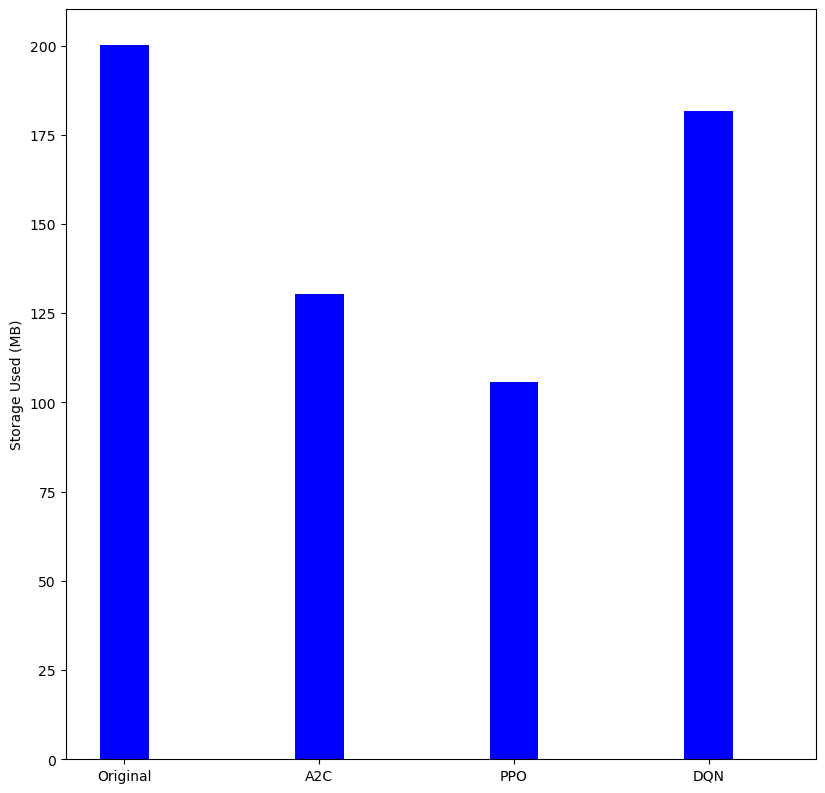

In [50]:

a2c_chain_size =[174208641,125778025,126388900,134067710,134887743,130690276,131820787,145783906,138051906,137967909,162328267,122508541,122487613,147717660,121071588,148798316,121060729,125870624,135479980,136753393,149588154,142827999,125798130,150181257,132779463,113964215,152825075,153203742,127785778,135622957,125878568,122426986,149023268,128020392,159419473,108212273,143859354,145292858,138636377,139161117,136634772,133158276,137924666,126203592,138832498,120337730,127493896,142780150,137509127,125807291,133433359,115545853,119168385,143684201,139249073,184110713,137360299,131279852,145587374,121232371,131518891,146980083,132281462,137619015,137664012,144185565,146857137,139880552,123685956,126445953,135523689,134391777,137540041,146771239,153872927,153637948,129651237,132284302,116733577,135868248,126992586,110940851,140977563,135097582,127707311,130742653,139064758,129764132,144118570,126255152,130274460,128453514,136970374,143330606,129788649,135743729,139404015,110568541,134619408,142850338,141762122,141516226,142592412,142583319,138167384,141405052,142394663,141076726,148936086,140774947,115623001,140393824,138542611,141959130,151339956,141111276,143646738,148166971,140100857,132601372,146764291,116268006,141435584,113745696,120674984,114254843,149551218,145590749,154703512,126085392,132558292,122575263,151600775,147994675,125547064,111274830,119673969,161078041,121070212,137899248,132185566,127920107,139545024,123351419,124547681,142270465,109338108,118396935,123474240,137005669,126133868,137668728,137628499,147382158,145583917,147167555,141684106,142592286,128501110,134435414,128862185,161988523,135279218,127149605,145075651,131852036,139138083,124743157,127534396,144426368,158109605,149843064,144738871,130145970,149863855,149382970,128869186,132170583,143927089,138793989,153806682,123635257,142308906,138679877,139857657,129581894,119046037,141195195,117193247,134775789,140912635,163510573,159723636,144981152,123051576,154811727,140855742,154127886,163682612,157743533]
a2c_init_chain_size =[226541197,216938379,215497665,208995138,202562431,200106887,196211944,206714006,207861105,209475456,209703946,213564108,219003777,216321553,213028488,218610620,188599738,207958551,225939958,206492696,217856957,213643194,188993024,220733825,197794729,211338740,210979799,201257956,206559094,204580517,211549624,199712410,203313626,205771467,212332335,190578150,214999497,213829724,213958564,212872503,205999530,201033741,197538464,206624673,225682437,193774178,198360342,207331675,212266345,198702297,212370933,211720859,195069104,217448272,205354474,230983224,210319580,199610806,223705630,217541944,212575987,206447457,205003653,195579934,211363269,211652919,204484148,219051837,213890761,200567290,214566182,221111428,213371732,218131822,213702723,222368149,221053375,193650966,207169771,208102465,200865622,205092227,211088961,210424083,203011589,206587758,202303397,199087900,204273881,198428662,214445690,207412035,196716340,223384278,206650473,214690679,208962249,211692917,204081330,207317484,205433654,215771351,210757576,220505884,215818442,217818859,202491288,215894662,207514316,204144051,191647328,233382056,209179927,215320558,217279715,206322866,215477202,209542753,197736419,209847009,221518355,199314187,213983002,200533394,200922419,201176224,221616680,204930792,211136876,203128640,203441835,206644953,213602721,212729958,204180777,196389136,197260324,228978433,195149296,213732897,224645382,196565515,201156474,201661287,202268950,224943547,204205941,202964769,195422931,209033452,218892722,214115671,203184883,216034757,216855931,214973973,200343316,212502544,205398958,222842918,197365337,217346151,209157523,211233721,222982337,206672451,211071679,204777314,215553273,211914526,215401688,208018266,206734917,210941412,198065360,217585403,213224856,200789988,220202397,222354990,220194064,210645388,211492581,217350322,198382786,209272570,201446311,215367107,213069883,215845049,222282784,219176265,226229733,230220841,207538947,225190553,224653796,210414416,212617864,221477475]

ppo_chain_size = [101810183,100419517,119998532,107422883,106877999,104930093,99079712,112588011,109170300,105827000,123212410,114769542,105131690,108445922,104086336,110524479,118408267,104113719,115531276,109298757,129128687,111626264,101038806,110771419,108942444,105156169,94890362,113405552,119158461,119008282,108603997,104492896,115616306,110471839,125210700,106644201,111160221,109602629,117979798,89409112,110217432,107962950,86782030,113671903,110622516,127485261,106784297,129174204,101848802,110959027,108799515,109628737,112144263,121152910,107313181,109703665,101298315,114475527,105429211,107219060,109983035,125003279,108371573,116986193,113120960,114389952,103176390,112871119,117284370,109287980,110470745,108824937,118044304,110912247,96765682,112146580,106441766,113684011,129980895,110622254,122090322,106320780,109934803,113556208,100849368,102349727,108906605,112570156,122684427,131784049,104791742,120538148,114489725,104087136,110393898,101140749,124485414,107163301,97332685,112773301,104950897,104548510,117098187,125993805,105682913,112366490,98877460,100578311,113744519,114559268,106263220,104967341,103366635,128619641,112378924,104984268,120947916,114891682,105654690,135443928,105888021,105605805,100602678,107320574,119245738,111990951,112635901,107269237,102834260,120844301,105307105,99198557,93840585,100664461,109002963,99286886,110549187,124247395,99808095,120994632,101864188,124061529,117809188,120177054,107813811,118028086,106832719,124984234,90033050,125526499,113628900,105890626,102862493,121072563,118912692,128706874,106589703,119532585,99559909,121550509,123724087,117422159,104630395,104026805,112959694,109914329,109145306,118573551,102199149,118881642,96806786,110160943,99629102,120013216,117859525,135030420,111658451,110421986,97797708,103790565,109939489,103036818,103300678,110797794,113106110,116098755,103056969,110986320,113872049,115694992,125856576,118438149,108884789,100257099,101845589,111608446,92409107,90838083,117227876,119533156]
ppo_init_chain_size = [208072018,205493806,225077121,206528788,211947671,192019748,204738027,198027037,215329027,212337508,204072754,212086987,210402508,213725194,210247330,215859505,203110224,209290913,221099652,195346549,211555476,217643477,206836067,215715347,213912508,210144624,200960299,209965197,210103871,219648811,214646423,209443114,220736953,214807181,219049173,195460506,216240420,205982281,208506275,194274570,216674963,212581319,191778523,218799610,217116818,202766698,202544644,218505390,207162248,202885275,214183153,214652362,217857571,209366957,212982338,216449522,206484238,220788510,199174764,204818355,215434750,215306709,213371509,221858148,218675055,219720066,208797842,197743287,211519894,207154537,215971836,209236317,207099598,207814850,194529177,198899426,212100536,218717907,211135871,205031832,217400052,207391134,215339266,218763470,205872091,207342087,206696110,218412803,220933411,213530909,203657198,207501686,220314367,183032795,215940813,200080194,218556473,212785140,202549909,217704927,210450198,210625055,215750464,215318472,211431245,213002788,204032785,205486087,213297614,219432152,203193392,210862192,208718838,222133754,217818872,210697112,202343636,206293150,210835343,215390621,210836186,197151247,198228771,194700900,224588210,217278656,199594082,212184719,208988382,198955821,211155860,204513895,196527092,201174376,214169009,205137008,206825583,224640941,204917224,227645703,207542097,229264123,214683252,208891183,212932770,202637413,212298869,215760412,196132987,219623151,218957699,203225117,209126962,211352658,215885477,227897697,211515881,208742953,204735512,226509713,212888560,210017691,209949111,209139954,203044962,205098051,198334390,210776259,187036061,212286313,202241375,215311390,202502916,206045861,214216837,216403655,204788587,216724715,199538202,201034120,215095159,209098205,202752539,215660372,204677771,217713607,208737861,217511458,219658395,220747591,219075645,205321114,200377719,197014493,201861009,217534298,197268748,196317280,215622201,218981844]

dqn_chain_size = [184548414,190591350,194645750,196414944,184831724,195884516,173638927,192563002,202153968,193689342,186194255,188726505,192733669,195681586,174887269,185553349,184491990,203855976,198943076,194478113,190056619,193894132,189108574,192342197,197830141,188764204,192347724,191442443,199250475,185189681,178473823,188367270,205232198,196708527,190131369,193253087,195266973,178131784,186762785,195791655,204285257,186418439,188908436,181918688,190831410,188253220,188748086,200896778,187628717,183682983,204159049,187436555,181460287,190592991,201452995,197114195,192728900,206900292,193842594,176526916,174087960,195707804,202292684,188648681,179804047,188351889,192779858,199181150,195284171,192091846,195676721,192404721,193836835,188936210,205678694,201455291,194855315,191321612,195729119,194504561,178068553,187377650,191950164,189679839,192136238,189325816,182877839,194353989,168346172,185422711,194365878,209262461,190611072,185957525,198021616,185969481,192741399,194415688,186425589,174010237,194117824,196160499,189294683,186533427,185908169,186894763,206290806,172839586,185888465,195296101,182710546,198122329,184026036,198848252,202913269,182345308,196007297,191647674,183240128,191224171,202895372,184364998,168720286,194349590,185702196,186163831,195616545,186159237,188891970,183392768,193454105,181310584,186570116,202853195,203584454,188537222,184091904,184579149,195295216,189212892,190361254,180534717,203469104,192674424,201005348,213105440,186558599,197674523,185419759,189571759,195257851,193345834,171354764,204901034,178802782,193815146,201983495,187893461,189393610,199279641,181944020,188580818,182001889,179560232,183077770,195721193,202051701,197687890,184632823,186859050,187782075,187813671,185891297,188810659,201849623,196155512,197871634,187236464,189412227,187216485,188682630,186918830,173257562,184096020,195899830,195536373,191956337,171202984,204243957,190319229,195533724,185214621,190617643,211691829,193085438,172462743,186195946,177141595,196091508,183661988]
dqn_init_chain_size = [206642803,209975224,209701951,218416437,204082386,216320396,192911012,206589071,218920902,211147777,208841531,209877142,215575522,220353399,194354822,212407566,210818837,224674704,216664768,207453982,212442540,220460027,202309711,204490013,214472444,212492279,211538026,212616207,221503063,211067618,200933526,212820738,212177670,214235282,210615466,210705755,220348251,196261911,199635394,209046911,221141614,206369075,202901048,202900898,210676507,212070762,212628989,216157936,209676823,200471495,222479580,200792450,203377969,208227839,215747146,211275337,210426573,220107526,210665930,196984424,201699221,212142172,222403670,205658968,196196623,208299864,215114286,214506233,211079349,209127066,209593451,216920924,212145586,206279614,219879252,215300482,212734770,212592021,221060873,209189746,202753953,208944283,212242892,202504518,211679618,207389479,202636227,211000047,189542478,202436009,213305431,226205160,211790408,205280632,215337005,204377697,212804235,212304053,205866196,198194751,217634517,217921117,205833874,208812919,208383716,203797962,220891793,195262846,205937172,208895966,207321743,214173282,199631325,211227688,220615166,204654016,219931867,207159162,198100407,206205138,217509477,207930092,199948164,212463795,211474172,204071616,216536350,199365680,205430957,207507773,203987510,197141202,206042511,221806141,223226483,210969867,208293675,205267197,208604986,216452787,205768244,200154228,229018008,209821309,209175287,230664365,204227498,211066542,208886354,219291885,206698908,218973806,188927218,221337913,197305427,215382259,215125758,209430346,209164336,213234793,204407021,205566861,200701016,195721842,203558966,220853974,222028105,214398027,206091564,203392293,198195899,201286707,202055463,206500573,218203065,213815398,218355825,205510820,214443818,201897160,213543610,209342976,199525797,209069134,210546306,216531549,212880833,199784572,220766548,202801888,210255577,201581669,206363024,224869310,204629181,186531081,209607178,198114493,217571768,206687382]

loc_a2c = np.mean(a2c_chain_size) / 1048576
init_loc_a2c = np.mean(a2c_init_chain_size) / 1048576

loc_ppo = np.mean(ppo_chain_size) / 1048576
init_loc_ppo = np.mean(ppo_init_chain_size) / 1048576

loc_dqn = np.mean(dqn_chain_size) / 1048576
init_loc_dqn = np.mean(dqn_init_chain_size) / 1048576

X = np.arange(4)
X_ticks = ["Original","A2C","PPO","DQN"]
data = [[init_loc_a2c, loc_a2c, loc_ppo, loc_dqn],[0, 0, 0, 0]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)

plt.xticks(X, X_ticks)

plt.ylabel("Storage Used (MB)")

#plt.legend(["Original","Proposed Method"])

plt.show()


In [28]:
a2c_percent_storage = 100 - ((loc_a2c / init_loc_a2c) * 100)

ppo_percent_storage = 100 - ((loc_ppo / init_loc_ppo) * 100)

dqn_percent_storage = 100 - ((loc_dqn / init_loc_dqn) * 100)

print(a2c_percent_storage, ppo_percent_storage, dqn_percent_storage)


34.89655552132304 47.25985730055039 9.038102090523097


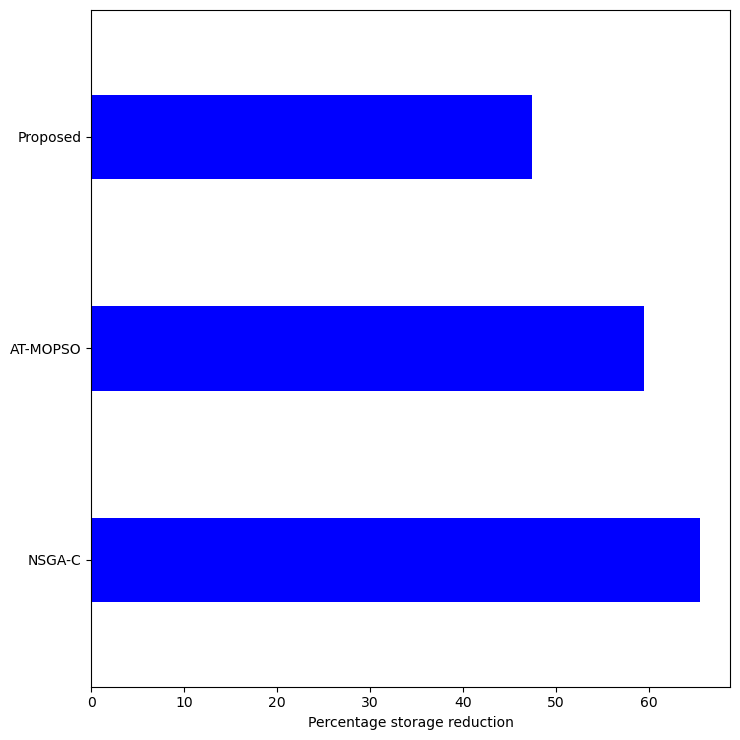

In [49]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 7.50]
plt.rcParams["figure.autolayout"] = True

per_values = np.array([65.5, 59.5, 47.5, 100])

# Array for horizontal bar's position
ind = np.array([0, 1, 2])

# Bar's width
width = 0.4

fig, ax = plt.subplots()

# Horizontal bar plot
#ax.barh(ind, np.array([0, 0, 0, 0]), width, color='orange', label='N')
hbars = ax.barh(ind + width, np.array([65.5, 59.5, 47.5]), width, color='blue', label='M')
#ax.barh(ind + width, np.array([0, 0, 0, 0]), width, color='red', label='N')
#ax.barh(ind + width, np.array([0, 0, 0, 0]), width, color='red', label='N')

# Set Y-axis ticks and ticklabels
ax.set(yticks=ind + width, yticklabels=np.array(['NSGA-C', 'AT-MOPSO', 'Proposed']),
ylim=[2*width - 1, len(ind)])

ax.set_xlabel('Percentage storage reduction')

# Legend at the upper right corner
#ax.legend(loc='upper right')

# Display the plot
plt.show()

# Objective Function Comparisons

1. Query Probability

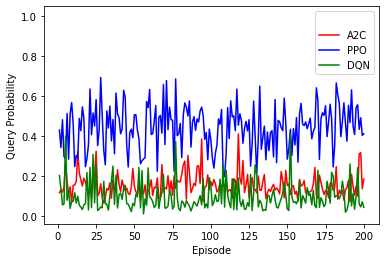

In [26]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

ep_list = range(1,201)

more_space = np.ones(200)

a2c_query_prob_list = [0.119114367265871,0.13333056828323,0.121788123718136,0.148370685884331,0.267600289531582,0.176027921406289,0.112960521923982,0.14787452013497,0.0700045306143977,0.155938551551227,0.157572958560222,0.175086598007993,0.323902077512043,0.217206043150957,0.184876065027128,0.151923860233805,0.191398374716603,0.17195609356272,0.142428974456067,0.107985172790499,0.149819285015879,0.0914473516044189,0.170743657159277,0.206375099459288,0.325674162266664,0.102937834107023,0.117520918620935,0.163419293787601,0.0924209415564378,0.0671595009564277,0.0931755135395171,0.139401693466649,0.132091429624157,0.16751711609608,0.0910668831722792,0.184108533971666,0.126724884465111,0.140223750079771,0.233219018538975,0.159630404490628,0.124182727638419,0.182487248909089,0.147584935854549,0.128241167531315,0.141576190046553,0.115585563758237,0.109300877198522,0.147349326152602,0.23933315284628,0.151495757420291,0.123247665258254,0.107999955292301,0.174515066585804,0.078254632835822,0.135693914239986,0.112898682182214,0.157807390215249,0.0826105904638485,0.126414331564085,0.143830775848692,0.183044337642237,0.105409466316246,0.146298420861257,0.142534355916488,0.192855153691149,0.0891253799160185,0.0932184007273602,0.258624749462269,0.12211254262225,0.143788824528859,0.137599582618837,0.203591504263151,0.122057005724617,0.178542675561199,0.106345513882033,0.202984697111786,0.141330164522617,0.181903034040397,0.174191759265202,0.172591117787576,0.212054449033328,0.257756968019018,0.276716295764295,0.0863614884604013,0.305207740791143,0.218859396586067,0.118764310195521,0.140500890039531,0.16562945954146,0.15419866462717,0.250719923200271,0.254185586784496,0.164689876350969,0.387391881039775,0.0745000651054669,0.14611440211097,0.15083823558018,0.207624097365779,0.132863607731936,0.173920355471567,0.153674480167359,0.184841536437143,0.162094212974111,0.122516171074089,0.134269238511389,0.165894497121603,0.149078180448779,0.159797061314188,0.153072314273733,0.173176587477558,0.120520600050189,0.133527322124382,0.132662219883414,0.0917933103105647,0.18820909431282,0.176969816228333,0.135690176515145,0.412799613027203,0.19262637899479,0.161108234066256,0.279155627701674,0.118992173647236,0.155671609573833,0.210687507306408,0.0935711070962396,0.159731778894534,0.194364842119271,0.133187273819311,0.135423587382409,0.117338894827712,0.202642777248397,0.132313087386658,0.130279614742468,0.17353018544332,0.209651037286428,0.0888181419500352,0.117251409819229,0.136135795698498,0.124638932895752,0.145809281360809,0.16048626405925,0.131423782005472,0.142956005181958,0.132393742694807,0.112768097327156,0.224560768589911,0.179579793662997,0.0932871872866489,0.230573664157747,0.154867774909721,0.162450711821043,0.10936882489985,0.14937481238499,0.154734524259089,0.112176531633306,0.126722745369014,0.0758230868491163,0.185964615157184,0.151823893088536,0.157005999979256,0.17966963119574,0.117418646865656,0.130787273758525,0.118759493425861,0.124439127058449,0.130342489997466,0.161849387387608,0.245228372911346,0.106540246490892,0.0900051170855842,0.206538684818838,0.169985298153448,0.138077040273793,0.109762003088638,0.129958483805212,0.126452956482339,0.0936265681943696,0.165499354168628,0.169362616358109,0.130903046375264,0.142562201506356,0.248734682349966,0.0861148916980847,0.13127984050894,0.11657777015175,0.131236118086359,0.0813255303655481,0.134012834559168,0.143236279599551,0.180990610668271,0.0738071822982517,0.210984212385583,0.149856667219269,0.106695169152691,0.152121003118212,0.101436744878445,0.313136668554618,0.318689261184736,0.138264675939682,0.18696924726954]

ppo_query_prob_list = [0.431656355586203,0.344355364534469,0.483065307143544,0.299487220333091,0.287387585409192,0.514223564913881,0.286157333078995,0.511631104092814,0.568958554573729,0.461889321485754,0.249014192704812,0.304925704233927,0.292348997915243,0.490270575711429,0.428359212743832,0.547473064702568,0.489493616702377,0.24828241058479,0.289407534265407,0.358725686053674,0.636796093100604,0.408303050738783,0.516886893964748,0.452294355503401,0.583621104949818,0.353818737788322,0.432985063330201,0.694030538657302,0.500640872571142,0.330026901337352,0.258380415391303,0.527370039109809,0.441949992806049,0.551162381228144,0.377484925527706,0.484445563874861,0.313591363904616,0.616521638137515,0.510824503194992,0.494143191721356,0.413316271923844,0.437073617104275,0.630280840690231,0.59528279383521,0.35606898703012,0.247179062539832,0.419106931668182,0.435998972974402,0.39354160260762,0.50818558595848,0.50790722099978,0.430733872666007,0.387458797049003,0.263495879754173,0.278488194267722,0.287019635125369,0.293843785692816,0.574399080540222,0.543205808364019,0.63387048902952,0.409838585522565,0.414139796529979,0.476377550677366,0.553717634894789,0.225685823908487,0.495930247312052,0.504617872521423,0.416100254734622,0.658974084398999,0.359253523442531,0.678557434267184,0.433854925035852,0.546364596324255,0.484217245323717,0.4799326659477,0.226293806230724,0.687221614952826,0.403743175726889,0.411843039769729,0.4649915468278,0.294111358175115,0.507809959196113,0.567556397358628,0.546379666513951,0.501900527129571,0.57737555791021,0.346303040627465,0.472351748638706,0.498806252940781,0.429980164040385,0.487565807745423,0.472038735404859,0.527155976106112,0.546359139029374,0.50433988566391,0.385352203777521,0.419316833988724,0.283418141151592,0.436620784648594,0.382566477043109,0.292551365775463,0.241710033322314,0.316675028660568,0.357288619104252,0.486978986387215,0.460600299614239,0.534815308252867,0.230440225299746,0.199501665634292,0.313242511862131,0.544116263978394,0.389107936746166,0.57754520066412,0.497099795558659,0.502749556417576,0.428966967020151,0.636123273066053,0.455574795083493,0.512812011718133,0.479272548054757,0.365312881276374,0.438316354602669,0.475128648006066,0.427323357703452,0.483384227413319,0.251092543152236,0.360196990499793,0.576454688903674,0.39330532152104,0.215224829466127,0.381036713144153,0.650702226605525,0.335580375117403,0.394311116009403,0.451407923738223,0.282974652127863,0.421794084512773,0.32883604476361,0.419372818952071,0.428579253007358,0.297705351835985,0.584188149761816,0.269366640668989,0.479658632006532,0.472899352855717,0.443895386842685,0.42795648397422,0.591245824773574,0.466960994234999,0.286319815286276,0.339006527748538,0.435046127662707,0.30493535679799,0.439305437606821,0.357040918744133,0.493977776102643,0.270895470089032,0.514727164041859,0.564507042303074,0.460782312448994,0.454306132392977,0.472088770845754,0.438549012825428,0.463368020556457,0.491232832745711,0.38825931758731,0.424386789464669,0.443421877622759,0.642586735339834,0.580148280634934,0.28539371755196,0.488632261816855,0.517624109049969,0.50483060357186,0.552708493860475,0.398982610631112,0.473192966636291,0.560675357558513,0.484542432445902,0.247500376644198,0.358204837902866,0.667276655381729,0.608124747538183,0.564816358830575,0.399113700639429,0.47355868984796,0.56753834525487,0.467830098099173,0.376346197075316,0.555271830702893,0.469340593255452,0.63221565730297,0.450561425764323,0.409553279380474,0.544737105215589,0.557919713734933,0.434860419194962,0.493176445858717,0.40567160794335,0.412929570242266]

dqn_query_prob_list = [0.204771418726027,0.137535487439544,0.058015145527921,0.062044931465191,0.401065747206858,0.0807158864839339,0.132953308262731,0.0403856555272692,0.0774501072966305,0.0756396905840802,0.118994742206622,0.0670885995919765,0.10087448389918,0.0557637979793514,0.0470647068616189,0.034600360474241,0.0580426086642967,0.0649654036812034,0.21894789505879,0.0327644912166333,0.245102098598914,0.0445868173502537,0.309477309703152,0.0678979485810178,0.260401756103573,0.0293995344236499,0.0368524300270745,0.0480832416347735,0.0432693030762849,0.175902703200485,0.0631720976414275,0.0624691634489637,0.031926192532551,0.104580478230879,0.176273359926128,0.251607610313483,0.06083207803487,0.205868598019921,0.0424324530178643,0.108853187355216,0.11735271274415,0.0858544517094654,0.140353972990566,0.156561450712288,0.0638294382745709,0.0620222850437682,0.0435375971006499,0.0247131319407843,0.0658665207267758,0.0536342889937811,0.110567639210807,0.0980798926904657,0.244650474559416,0.0434324561442489,0.229565032870384,0.0128692386772726,0.0887122744805526,0.056081848270191,0.242632831299195,0.0982534789758852,0.0901446177807145,0.0741049655188628,0.0449078190302245,0.0547222175817126,0.14935663139232,0.0399748099564686,0.0915751922583305,0.119114883618226,0.210385210211143,0.0417109068840936,0.0431304171539545,0.050993491754352,0.131340761107455,0.106254868416348,0.0371803181683595,0.0500378064755275,0.373980903948539,0.0977154690276259,0.0391186680187748,0.0290364006220352,0.0767818638102692,0.0693359288940505,0.0466170265822121,0.0791327845078354,0.0656900196570775,0.0520783545188509,0.0273842349482091,0.0482046852534818,0.0746341113068493,0.0619458625264072,0.0520718572567112,0.0788937426934782,0.104175196677083,0.0580966301560929,0.187252842249849,0.0434316294187692,0.0634015475036019,0.0422585231495484,0.193744003642903,0.15423367005346,0.0543444283475775,0.0726270704023902,0.109455016435355,0.0749979064828108,0.0773418585309989,0.186824413366985,0.0637888315848737,0.2566166142147,0.0468208959380981,0.231203450670941,0.108578308533507,0.0688326194643708,0.0434135478598268,0.187994153368213,0.0344741351566784,0.182288024089518,0.0335162943499627,0.192618287142108,0.0771596058954708,0.0502103018642509,0.0836266882176711,0.0360224439868075,0.0373022781436504,0.0688531543824221,0.0510465535820603,0.209878830644774,0.0299802169014988,0.11873505158655,0.258487359499323,0.20880027742176,0.0477589901643698,0.0808436039850945,0.0657023463550456,0.028335151534274,0.0344629907501495,0.0307263254121674,0.102409919717102,0.105553874456494,0.0672172383789013,0.10390340356082,0.135970636927554,0.0832788786577915,0.0466905273081986,0.0423679694424211,0.0677339379330641,0.0889097873809685,0.114901125991595,0.171858984586582,0.105355501834497,0.0383032031761638,0.0300046542217592,0.411990165172863,0.0984279635761696,0.0703246453878222,0.0733892960167437,0.0636849279061347,0.0848125882233985,0.177174500806471,0.0430377979088245,0.105363624441082,0.0875664374825161,0.0661959693155003,0.144135914732404,0.10454846377332,0.113387738249962,0.0577948872987185,0.130894237693964,0.0532785729638434,0.043885028069822,0.230443260489362,0.0455534685227764,0.0935385989578382,0.0760958346715768,0.0492788331807457,0.0645413097244054,0.17585984173211,0.132351246917515,0.0665870226699651,0.221108773974263,0.200325622715262,0.0963485333797889,0.104078784511214,0.100350076059047,0.0890815109822219,0.107552605705866,0.176307588931971,0.129974258367448,0.0214559723731815,0.032238120827982,0.0681830272488981,0.262098238829001,0.0522864793344859,0.115434492719958,0.0359363604325294,0.102462811244352,0.243582511395549,0.0617809477859305,0.0480032593101613,0.0737292726398154,0.0454577103958641]

plt.plot(ep_list, more_space, color = 'white')

plt.plot(ep_list, a2c_query_prob_list, color = 'red')

plt.plot(ep_list, ppo_query_prob_list, color = 'blue')

plt.plot(ep_list, dqn_query_prob_list, color = 'green')

plt.xlabel("Episode")
plt.ylabel("Query Probability")

plt.legend(["","A2C","PPO","DQN"], loc = 'upper right')

plt.show()

2. Cloud Storage Cost

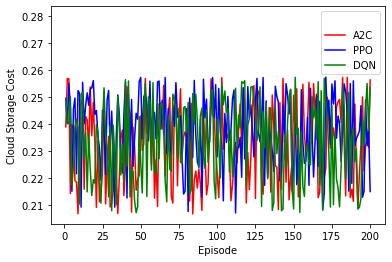

In [27]:
more_space2 = np.zeros(200)

for i in range(0,200):
    more_space2[i] = 0.28

a2c_stc_list = [0.23893903030303,0.256946957575757,0.256759078787878,0.214211296969696,0.239715757575757,0.238653939393939,0.218979321212121,0.218438424242424,0.206705139393939,0.245245648484848,0.247656121212121,0.249328072727272,0.215802666666666,0.242750957575757,0.241464872727272,0.230735975757575,0.253747224242424,0.23563263030303,0.247980921212121,0.233114739393939,0.209085066666666,0.233863321212121,0.211224824242424,0.213990084848484,0.22260909090909,0.252161745454545,0.210388606060606,0.223895151515151,0.235458666666666,0.20922766060606,0.210557963636363,0.215197915151515,0.229493624242424,0.2205512,0.206798787878787,0.220054012121212,0.234807006060606,0.237771587878787,0.213467587878787,0.224377454545454,0.253927951515151,0.246843612121212,0.244049309090909,0.207342424242424,0.238807442424242,0.23129806060606,0.215437527272727,0.219484387878787,0.220897066666666,0.242989284848484,0.230176993939393,0.232500145454545,0.256922957575757,0.236480266666666,0.247197769696969,0.239266109090909,0.224790618181818,0.244776412121212,0.212479903030303,0.226620727272727,0.209407442424242,0.247461333333333,0.247853672727272,0.238127272727272,0.254348727272727,0.220710715151515,0.235386981818181,0.243473187878787,0.249846618181818,0.213058424242424,0.210656557575757,0.248667224242424,0.252031927272727,0.21706429090909,0.239512509090909,0.253068727272727,0.22862606060606,0.23520509090909,0.237132072727272,0.234963733333333,0.240025357575757,0.211390909090909,0.247681381818181,0.206653575757575,0.219317163636363,0.222583951515151,0.216293042424242,0.223304145454545,0.217525478787878,0.207971272727272,0.245141478787878,0.23086526060606,0.213777939393939,0.217759903030303,0.236754642424242,0.256776993939393,0.243392121212121,0.24263263030303,0.230793769696969,0.221939951515151,0.212706593939393,0.229203345454545,0.257230981818181,0.23068669090909,0.241515127272727,0.234682715151515,0.236242618181818,0.229054642424242,0.211553842424242,0.217410812121212,0.226231733333333,0.233124218181818,0.225624606060606,0.237758206060606,0.247499466666666,0.230732436363636,0.253274787878787,0.247839272727272,0.210731006060606,0.229374957575757,0.21564509090909,0.227279248484848,0.246010715151515,0.254237357575757,0.212406012121212,0.252647296969697,0.252039345454545,0.247613624242424,0.219926981818181,0.21393309090909,0.232729284848484,0.239249575757575,0.221490836363636,0.246150521212121,0.214759806060606,0.250761454545454,0.239617769696969,0.224592484848484,0.223964969696969,0.208271442424242,0.247910012121212,0.215683296969696,0.256928096969697,0.241839321212121,0.218410666666666,0.237704169696969,0.211862521212121,0.220070836363636,0.225914496969696,0.250725018181818,0.235751903030303,0.253104387878787,0.212987806060606,0.228806133333333,0.225959903030303,0.254791272727272,0.236886181818181,0.227924872727272,0.238555103030303,0.255488048484848,0.240093721212121,0.232561454545454,0.25499646060606,0.244863612121212,0.251046569696969,0.212672678787878,0.2147712,0.23169486060606,0.22521646060606,0.220336048484848,0.223648436363636,0.249925624242424,0.241102278787878,0.231099345454545,0.233988145454545,0.238540048484848,0.232352339393939,0.246314787878787,0.248244339393939,0.249168654545454,0.240572266666666,0.257306642424242,0.233384048484848,0.213342157575757,0.257331151515151,0.237204096969697,0.212711466666666,0.215821696969696,0.211337066666666,0.24737869090909,0.224171951515151,0.208999684848484,0.221919757575757,0.23242366060606,0.250024266666666,0.22258446060606,0.231707054545454,0.233936557575757,0.231305648484848,0.256350181818181]

ppo_stc_list = [0.249568654545454,0.240109915151515,0.25512509090909,0.246008193939393,0.215057842424242,0.24575326060606,0.249630036363636,0.221553987878787,0.252427636363636,0.251444921212121,0.209182787878787,0.255503272727272,0.240070375757575,0.247090787878787,0.251579393939393,0.2469592,0.252918763636363,0.253470206060606,0.256113527272727,0.243512824242424,0.245036872727272,0.235855393939393,0.230985818181818,0.219147757575757,0.245174303030303,0.238569769696969,0.22124989090909,0.248874351515151,0.252475442424242,0.230464266666666,0.244784606060606,0.229405284848484,0.209164678787878,0.235293818181818,0.250803006060606,0.243461793939393,0.229024242424242,0.221901066666666,0.243865357575757,0.255602763636363,0.212541624242424,0.251056339393939,0.22775709090909,0.24912463030303,0.224303903030303,0.234932,0.243999321212121,0.241782133333333,0.255759878787878,0.257299127272727,0.234444606060606,0.250048848484848,0.251432387878787,0.247313503030303,0.233749648484848,0.255919587878787,0.233801478787878,0.244517357575757,0.244276872727272,0.23446989090909,0.255639272727272,0.255955927272727,0.238118763636363,0.248832533333333,0.235996024242424,0.257248436363636,0.229104242424242,0.245818521212121,0.2337008,0.228575127272727,0.24704589090909,0.239139903030303,0.255361987878787,0.242748,0.242077551515151,0.243085066666666,0.22778063030303,0.214021139393939,0.215134012121212,0.245754206060606,0.207519418181818,0.249669551515151,0.235364145454545,0.227510933333333,0.256180218181818,0.236008896969696,0.226001139393939,0.224093842424242,0.241777818181818,0.212893381818181,0.256632339393939,0.242292921212121,0.249208775757575,0.232222981818181,0.233165963636363,0.246705866666666,0.257272412121212,0.242373987878787,0.254650036363636,0.227870909090909,0.253230981818181,0.237415878787878,0.232028096969696,0.211499854545454,0.243966254545454,0.233176654545454,0.2502656,0.233883951515151,0.237930036363636,0.249382642424242,0.25264029090909,0.207029284848484,0.231630884848484,0.231165672727272,0.235063393939393,0.220262157575757,0.253523709090909,0.227066739393939,0.229455272727272,0.253862618181818,0.242295903030303,0.247046084848484,0.237411272727272,0.227781696969696,0.248605406060606,0.256949866666666,0.236657551515151,0.233386084848484,0.240580242424242,0.257259466666666,0.217260509090909,0.248594933333333,0.220221987878787,0.238850472727272,0.235167296969697,0.229845818181818,0.222306545454545,0.254035539393939,0.250124048484848,0.248105963636363,0.218903272727272,0.222144678787878,0.247072048484848,0.233165066666666,0.254995951515151,0.250757745454545,0.243723418181818,0.252702472727272,0.21519023030303,0.225674036363636,0.243285236363636,0.217532242424242,0.2307528,0.218919806060606,0.252766036363636,0.233270327272727,0.225402351515151,0.226305478787878,0.242606715151515,0.21726223030303,0.253264678787878,0.237006521212121,0.220344363636363,0.233456896969697,0.2508168,0.224240024242424,0.248384169696969,0.230259878787878,0.208451272727272,0.214230884848484,0.257416727272727,0.24276446060606,0.24886303030303,0.232527563636363,0.254852048484848,0.247462884848484,0.256046424242424,0.234763781818181,0.242986424242424,0.240205018181818,0.226091224242424,0.2369896,0.254879587878787,0.251928581818181,0.244343903030303,0.215113139393939,0.255017551515151,0.21802,0.256033987878787,0.232050812121212,0.234620363636363,0.23594783030303,0.23752383030303,0.246825721212121,0.212843296969696,0.215092921212121,0.248912315151515,0.232007951515151,0.238615975757575,0.214961648484848]

dqn_stc_list = [0.249452121212121,0.240498303030303,0.240132703030303,0.250247006060606,0.217168,0.223994715151515,0.238951272727272,0.241742496969696,0.238554496969697,0.210283515151515,0.250851709090909,0.251820969696969,0.22757389090909,0.236929842424242,0.214831951515151,0.236552654545454,0.223029478787878,0.213501381818181,0.219367636363636,0.218027103030303,0.239805042424242,0.237362618181818,0.218619078787878,0.210652218181818,0.239694521212121,0.253441187878787,0.236661963636363,0.231034521212121,0.212978278787878,0.239478933333333,0.207821721212121,0.239573648484848,0.228979878787878,0.210026351515151,0.250240169696969,0.2394144,0.221106036363636,0.232296096969697,0.218498545454545,0.2564792,0.224431539393939,0.255979636363636,0.212948945454545,0.223099127272727,0.222537139393939,0.211380387878787,0.207081163636363,0.209350278787878,0.242762424242424,0.225547151515151,0.21443869090909,0.245793696969697,0.255334036363636,0.213128678787878,0.250085309090909,0.248174254545454,0.222891272727272,0.255341769696969,0.222254084848484,0.221663224242424,0.247576799999999,0.227098812121212,0.247393721212121,0.247667733333333,0.238239442424242,0.2188976,0.211136751515151,0.243090399999999,0.223184775757575,0.222505139393939,0.251093478787878,0.249062618181818,0.24564766060606,0.227463903030303,0.245912484848484,0.225816218181818,0.225542884848484,0.246064145454545,0.246508896969696,0.236804727272727,0.248017769696969,0.213946981818181,0.215728654545454,0.251314545454545,0.240036193939393,0.251031587878787,0.241293478787878,0.223760121212121,0.243045721212121,0.245885745454545,0.227949042424242,0.223552848484848,0.245125696969697,0.225843539393939,0.234150303030303,0.252277212121212,0.252756848484848,0.218541963636363,0.212268775757575,0.241844412121212,0.231781236363636,0.220030303030303,0.254836509090909,0.247148193939393,0.252264993939393,0.244367684848484,0.245803515151515,0.222080412121212,0.237705987878787,0.220457115151515,0.231033769696969,0.253262157575757,0.231102157575757,0.243349575757575,0.238553939393939,0.255690957575757,0.255140145454545,0.25608829090909,0.216568751515151,0.239575684848484,0.242089066666666,0.253668,0.253967563636363,0.249257818181818,0.243434133333333,0.233842739393939,0.239476145454545,0.253839418181818,0.20942943030303,0.244508121212121,0.231147369696969,0.24775069090909,0.219718254545454,0.241104557575757,0.246006884848484,0.207959563636363,0.210832848484848,0.246198254545454,0.229046836363636,0.23734349090909,0.231467078787878,0.207831563636363,0.208428096969696,0.236080436363636,0.223723127272727,0.241018206060606,0.249907175757575,0.252942036363636,0.21546526060606,0.208490666666666,0.257339175757575,0.236220242424242,0.238443127272727,0.207274206060606,0.237105187878787,0.216870303030303,0.213112945454545,0.2290432,0.232939927272727,0.225231442424242,0.224884363636363,0.250130715151515,0.242332872727272,0.24580589090909,0.234384242424242,0.255701284848484,0.217499878787878,0.252372993939393,0.20798206060606,0.256925648484848,0.248135466666666,0.242931563636363,0.229024218181818,0.209194593939393,0.246874739393939,0.210056678787878,0.236635757575757,0.219583878787878,0.216258666666666,0.209300533333333,0.223915539393939,0.253608436363636,0.246618157575757,0.219632872727272,0.237456557575757,0.251657551515151,0.216239296969697,0.235536387878787,0.238452121212121,0.225953212121212,0.230911393939393,0.208448533333333,0.209165212121212,0.212478157575757,0.241564606060606,0.23210766060606,0.245696581818181,0.255044315151515,0.237526351515151,0.253647248484848]

plt.plot(ep_list, more_space2, color = 'white')

plt.plot(ep_list, a2c_stc_list, color = 'red')

plt.plot(ep_list, ppo_stc_list, color = 'blue')

plt.plot(ep_list, dqn_stc_list, color = 'green')

plt.xlabel("Episode")
plt.ylabel("Cloud Storage Cost")

plt.legend(["","A2C","PPO","DQN"], loc = 'upper right')

plt.show()

3. Local Space Occupancy

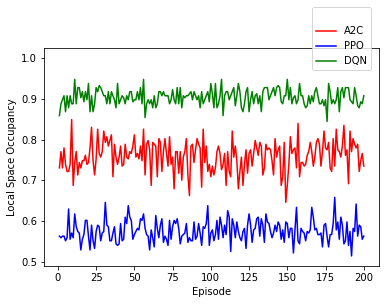

In [41]:
for i in range(0,200):
    more_space[i] = 1
       
a2c_lso_list = [0.730621423547166,0.770595987877258,0.730621423547166,0.779643263251748,0.739401311525123,0.721899873479961,0.721899873479961,0.739401311525123,0.849455011967345,0.687589338332085,0.743813254072219,0.770595987877258,0.713236273697623,0.743813254072219,0.730621423547166,0.74823992763252,0.74823992763252,0.761608827067403,0.739401311525123,0.743813254072219,0.779643263251748,0.830495930467305,0.74823992763252,0.713236273697623,0.752681381391334,0.825795526701351,0.76609491817859,0.757137664698194,0.770595987877258,0.821110764863587,0.793327771456605,0.807149811255385,0.784189569452945,0.797919768794739,0.811787958934018,0.708926084734919,0.788751055293489,0.757137664698194,0.739401311525123,0.757137664698194,0.784189569452945,0.735004050969605,0.739401311525123,0.788751055293489,0.757137664698194,0.752681381391334,0.770595987877258,0.76609491817859,0.784189569452945,0.811787958934018,0.757137664698194,0.76609491817859,0.752681381391334,0.784189569452945,0.74823992763252,0.825795526701351,0.713236273697623,0.788751055293489,0.797919768794739,0.775112086175339,0.687589338332085,0.793327771456605,0.788751055293489,0.784189569452945,0.708926084734919,0.802527098330134,0.793327771456605,0.721899873479961,0.770595987877258,0.802527098330134,0.76609491817859,0.735004050969605,0.807149811255385,0.739401311525123,0.757137664698194,0.679153714685924,0.770595987877258,0.770595987877258,0.717560853928991,0.770595987877258,0.700348689210746,0.757137664698194,0.770595987877258,0.802527098330134,0.713236273697623,0.662450246312401,0.784189569452945,0.788751055293489,0.743813254072219,0.775112086175339,0.802527098330134,0.788751055293489,0.779643263251748,0.683364496829141,0.825795526701351,0.743813254072219,0.784189569452945,0.721899873479961,0.739401311525123,0.708926084734919,0.735004050969605,0.713236273697623,0.730621423547166,0.770595987877258,0.784189569452945,0.76609491817859,0.726253380561904,0.739401311525123,0.76609491817859,0.687589338332085,0.770595987877258,0.721899873479961,0.708926084734919,0.821110764863587,0.757137664698194,0.784189569452945,0.74823992763252,0.679153714685924,0.721899873479961,0.757137664698194,0.687589338332085,0.739401311525123,0.775112086175339,0.717560853928991,0.76609491817859,0.775112086175339,0.735004050969605,0.76609491817859,0.797919768794739,0.779643263251748,0.761608827067403,0.793327771456605,0.784189569452945,0.713236273697623,0.730621423547166,0.788751055293489,0.775112086175339,0.779643263251748,0.775112086175339,0.74823992763252,0.713236273697623,0.802527098330134,0.757137664698194,0.775112086175339,0.784189569452945,0.687589338332085,0.708926084734919,0.793327771456605,0.645968012674745,0.687589338332085,0.739401311525123,0.807149811255385,0.76609491817859,0.775112086175339,0.779643263251748,0.730621423547166,0.839943872865189,0.708926084734919,0.743813254072219,0.743813254072219,0.735004050969605,0.739401311525123,0.761608827067403,0.770595987877258,0.793327771456605,0.770595987877258,0.735004050969605,0.757137664698194,0.793327771456605,0.802527098330134,0.788751055293489,0.735004050969605,0.770595987877258,0.821110764863587,0.779643263251748,0.775112086175339,0.793327771456605,0.730621423547166,0.721899873479961,0.802527098330134,0.735004050969605,0.825795526701351,0.775112086175339,0.770595987877258,0.757137664698194,0.784189569452945,0.835212028388206,0.761608827067403,0.775112086175339,0.691828286137481,0.821110764863587,0.770595987877258,0.802527098330134,0.788751055293489,0.779643263251748,0.788751055293489,0.721899873479961,0.74823992763252,0.76609491817859,0.735004050969605]

ppo_lso_list = [0.562951360819708,0.559141287577327,0.562951360819708,0.562951360819708,0.551559136200959,0.559141287577327,0.629704083554675,0.555343893435513,0.570609714084267,0.559141287577327,0.617647658247017,0.586080442021271,0.574458079199337,0.570609714084267,0.529113622653821,0.555343893435513,0.566774155496843,0.601758827638905,0.601758827638905,0.562951360819708,0.529113622653821,0.589980462273531,0.551559136200959,0.53282343667392,0.574458079199337,0.589980462273531,0.586080442021271,0.551559136200959,0.570609714084267,0.574458079199337,0.645968012674745,0.589980462273531,0.586080442021271,0.551559136200959,0.551559136200959,0.570609714084267,0.586080442021271,0.544027364381984,0.540280266111133,0.544027364381984,0.593893504284172,0.551559136200959,0.555343893435513,0.609676761656693,0.593893504284172,0.637808941666571,0.609676761656693,0.601758827638905,0.555343893435513,0.566774155496843,0.574458079199337,0.582193400193794,0.578319293601705,0.605711196375561,0.601758827638905,0.617647658247017,0.582193400193794,0.566774155496843,0.562951360819708,0.529113622653821,0.578319293601705,0.559141287577327,0.536545637373749,0.61365556754418,0.582193400193794,0.559141287577327,0.589980462273531,0.605711196375561,0.547786973820767,0.562951360819708,0.555343893435513,0.540280266111133,0.601758827638905,0.555343893435513,0.586080442021271,0.601758827638905,0.593893504284172,0.605711196375561,0.582193400193794,0.544027364381984,0.562951360819708,0.566774155496843,0.570609714084267,0.593893504284172,0.547786973820767,0.559141287577327,0.551559136200959,0.551559136200959,0.597819611531479,0.555343893435513,0.562951360819708,0.593893504284172,0.570609714084267,0.540280266111133,0.586080442021271,0.582193400193794,0.593893504284172,0.637808941666571,0.540280266111133,0.570609714084267,0.578319293601705,0.551559136200959,0.566774155496843,0.601758827638905,0.555343893435513,0.609676761656693,0.589980462273531,0.559141287577327,0.589980462273531,0.566774155496843,0.62567187167326,0.609676761656693,0.52541615409326,0.605711196375561,0.589980462273531,0.559141287577327,0.597819611531479,0.574458079199337,0.559141287577327,0.551559136200959,0.574458079199337,0.582193400193794,0.53282343667392,0.589980462273531,0.617647658247017,0.589980462273531,0.547786973820767,0.578319293601705,0.582193400193794,0.605711196375561,0.609676761656693,0.562951360819708,0.605711196375561,0.589980462273531,0.547786973820767,0.617647658247017,0.597819611531479,0.593893504284172,0.574458079199337,0.559141287577327,0.570609714084267,0.589980462273531,0.574458079199337,0.597819611531479,0.589980462273531,0.555343893435513,0.578319293601705,0.547786973820767,0.597819611531479,0.593893504284172,0.559141287577327,0.582193400193794,0.582193400193794,0.521730989909213,0.578319293601705,0.63374975856845,0.551559136200959,0.544027364381984,0.582193400193794,0.574458079199337,0.570609714084267,0.551559136200959,0.574458079199337,0.570609714084267,0.578319293601705,0.63374975856845,0.609676761656693,0.578319293601705,0.582193400193794,0.566774155496843,0.566774155496843,0.570609714084267,0.536545637373749,0.589980462273531,0.593893504284172,0.562951360819708,0.536545637373749,0.566774155496843,0.566774155496843,0.593893504284172,0.658309062276285,0.578319293601705,0.597819611531479,0.555343893435513,0.609676761656693,0.589980462273531,0.544027364381984,0.551559136200959,0.597819611531479,0.540280266111133,0.574458079199337,0.514397411021698,0.582193400193794,0.574458079199337,0.641881677951113,0.562951360819708,0.589980462273531,0.586080442021271,0.555343893435513,0.562951360819708]

dqn_lso_list = [0.859029770492631,0.888140032322578,0.897973552564244,0.90787284861661,0.868668573987448,0.90787284861661,0.878371850844648,0.90787284861661,0.888140032322578,0.888140032322578,0.948136634602188,0.888140032322578,0.927870530977747,0.927870530977747,0.902914951184688,0.917838360450019,0.893048597850797,0.917838360450019,0.897973552564244,0.937969806075693,0.868668573987448,0.90787284861661,0.868668573987448,0.888140032322578,0.927870530977747,0.917838360450019,0.932911752471931,0.927870530977747,0.917838360450019,0.90787284861661,0.90787284861661,0.888140032322578,0.917838360450019,0.888140032322578,0.917838360450019,0.90787284861661,0.897973552564244,0.878371850844648,0.937969806075693,0.888140032322578,0.897973552564244,0.90787284861661,0.902914951184688,0.888140032322578,0.90787284861661,0.897973552564244,0.917838360450019,0.917838360450019,0.893048597850797,0.897973552564244,0.897973552564244,0.917838360450019,0.897973552564244,0.927870530977747,0.888140032322578,0.948136634602188,0.854234412271938,0.888140032322578,0.897973552564244,0.888140032322578,0.897973552564244,0.878371850844648,0.90787284861661,0.878371850844648,0.888140032322578,0.917838360450019,0.917838360450019,0.90787284861661,0.917838360450019,0.90787284861661,0.90787284861661,0.90787284861661,0.888140032322578,0.897973552564244,0.922846085579517,0.897973552564244,0.888140032322578,0.927870530977747,0.888140032322578,0.927870530977747,0.878371850844648,0.90787284861661,0.902914951184688,0.90787284861661,0.90787284861661,0.912847299947809,0.917838360450019,0.897973552564244,0.917838360450019,0.90787284861661,0.897973552564244,0.90787284861661,0.878371850844648,0.917838360450019,0.888140032322578,0.897973552564244,0.90787284861661,0.917838360450019,0.893048597850797,0.937969806075693,0.912847299947809,0.878371850844648,0.937969806075693,0.878371850844648,0.888140032322578,0.90787284861661,0.948136634602188,0.859029770492631,0.90787284861661,0.917838360450019,0.917838360450019,0.897973552564244,0.90787284861661,0.917838360450019,0.927870530977747,0.883247801439918,0.90787284861661,0.937969806075693,0.917838360450019,0.878371850844648,0.868668573987448,0.888140032322578,0.917838360450019,0.927870530977747,0.868668573987448,0.897973552564244,0.917838360450019,0.888140032322578,0.90787284861661,0.912847299947809,0.888140032322578,0.90787284861661,0.868668573987448,0.917838360450019,0.927870530977747,0.927870530977747,0.927870530977747,0.897973552564244,0.90787284861661,0.917838360450019,0.927870530977747,0.90787284861661,0.927870530977747,0.932911752471931,0.927870530977747,0.893048597850797,0.888140032322578,0.90787284861661,0.90787284861661,0.948136634602188,0.897973552564244,0.927870530977747,0.888140032322578,0.902914951184688,0.90787284861661,0.888140032322578,0.897973552564244,0.937969806075693,0.90787284861661,0.90787284861661,0.888140032322578,0.878371850844648,0.883247801439918,0.90787284861661,0.888140032322578,0.90787284861661,0.893048597850797,0.917838360450019,0.927870530977747,0.90787284861661,0.888140032322578,0.888140032322578,0.897973552564244,0.883247801439918,0.897973552564244,0.844691516474354,0.937969806075693,0.917838360450019,0.888140032322578,0.897973552564244,0.888140032322578,0.897973552564244,0.927870530977747,0.868668573987448,0.917838360450019,0.927870530977747,0.902914951184688,0.927870530977747,0.927870530977747,0.927870530977747,0.897973552564244,0.893048597850797,0.888140032322578,0.927870530977747,0.90787284861661,0.883247801439918,0.878371850844648,0.893048597850797,0.888140032322578,0.90787284861661]

plt.plot(ep_list, more_space, color = 'white')

plt.plot(ep_list, a2c_lso_list, color = 'red')

plt.plot(ep_list, ppo_lso_list, color = 'blue')

plt.plot(ep_list, dqn_lso_list, color = 'green')

plt.xlabel("Episode")
plt.ylabel("Local Space Occupancy")

plt.legend(["","A2C","PPO","DQN"], loc=(0.8,0.9))

plt.show()